### COMP 484 Lab 2
Srishan Shakya

Roll No. 46

CE

# Classifying with Real-World Examples

## The Iris dataset

The dataset is a classic dataset from the 1930s; one of the first modern examples of statistical classification; collection of morphological measuresments of several Iris flowers. It has four **features**:
- sepal legth
- sepal width
- petal length
- petal width

Additionally, for each plant, the species is also recorded.

The problem we want to solve is, "Given these examples, if we see a new flower out in
the field, could we make a good prediction about its species from its measurements?"

This is the **supervised learning** or **classification** problem: given labeled examples,
can we design a rule to be later applied to other examples?

## Visualization is a good first step

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import load_iris #Iris dataset from sklearn or scikit-learn

In [3]:
data = load_iris()

# load_iris returns an object with several fields
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names
print(features[:10], "\n", feature_names[:10], "\n", target[:10], "\n", target_names)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]] 
 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] 
 [0 0 0 0 0 0 0 0 0 0] 
 ['setosa' 'versicolor' 'virginica']


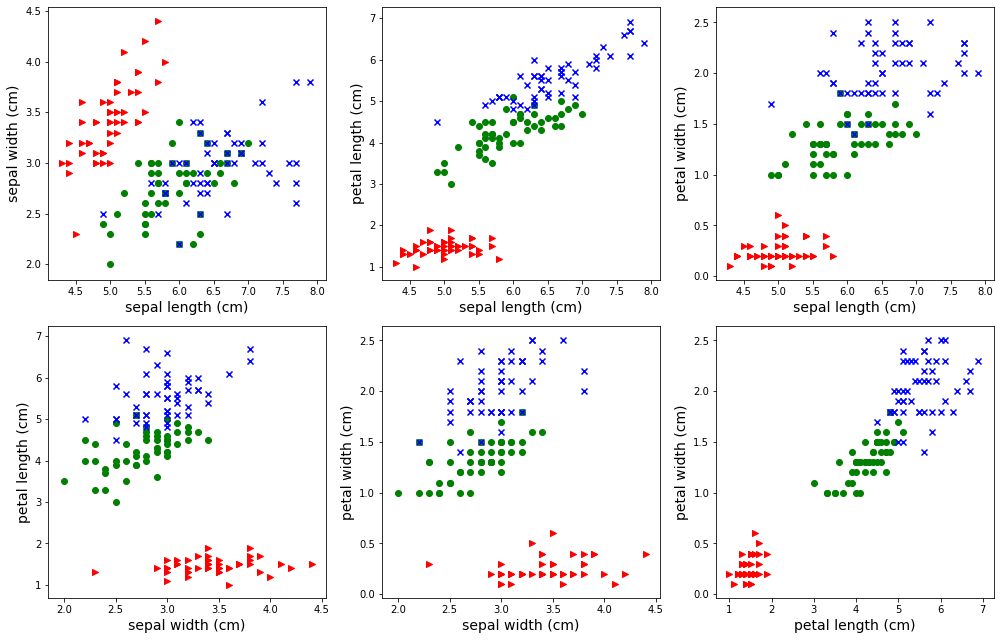

In [4]:
plt.rcParams['figure.figsize'] = [14, 9]

i = 1
for j in range(4):
    for k in range(j+1, 4):
        plt.subplot(2, 3, i)
        i += 1
        for t in range(3):
            if t == 0: # Iris Setosa
                c = 'r'
                marker = '>'
            elif t == 1: # Iris Versicolor
                c = 'g'
                marker = 'o'
            elif t == 2: # Iris Virginica
                c = 'b'
                marker = 'x'
            plt.scatter(features[target == t, j], features[target == t, k], marker = marker, c = c)
        plt.xlabel(feature_names[j], fontsize=14)
        plt.ylabel(feature_names[k], fontsize=14)
plt.tight_layout()

## Building our first classification model

In [5]:
# We can see that Petal length separates Iris Setosa from the others.
labels = target_names[target]

# The petal length is the feature at position 2
plength = features[:, 2]

# Build an array of booleans:
is_setosa = (labels == 'setosa')

# Important step
max_setosa = plength[is_setosa].max()
min_non_setosa = plength[~is_setosa].min()
print('Maximum of setosa: {0}.'.format(max_setosa))
print('Minimum of others: {0}.'.format(min_non_setosa))

Maximum of setosa: 1.9.
Minimum of others: 3.0.


We can now build a simple model to separate Iris Setosa from others as:
```
if petal length is less than 2 then
    flower is Setosa    
otherwise
    flower is either Viginica or Versicolor
```
Now to create a model to separate Virginica from Versicolor, we first select only the non-Setosa features and labels:

In [6]:
features = features[~is_setosa]
labels = labels[~is_setosa]

is_virginica = (labels == 'virginica')

Run a loop over all possible features and thresholds to see which one results in better accuracy.

In [7]:
# Initialize best accuracy to impossibly low value
bestAcc = -1
for fi in range(features.shape[1]):
    # Test all possible thresholds
    thresh = features[:, fi]
    for t in thresh:
        # Get the vector for feature 'fi'
        feature_i = features[:, fi]
        # apply threshold 't'
        pred = (feature_i > t)
        acc = (pred == is_virginica).mean()
        revAcc = (pred == ~is_virginica).mean()
        if revAcc > acc:
            reverse = True
            acc = revAcc
        else:
            reverse = False
        
        if acc > bestAcc:
            bestAcc = acc
            best_fi = fi
            best_t = t
            best_reverse = reverse
print("Best Accuracy: ", bestAcc)
print("Best Feature: ", feature_names[fi])
print("Best Threshold: ", best_t)
print("Best Accuracy is reversed?: ", best_reverse)

Best Accuracy:  0.94
Best Feature:  petal width (cm)
Best Threshold:  1.6
Best Accuracy is reversed?:  False


Above result shows that

```
if petal width is greater than 1.6 cm then,
    the flower can be classified as Iris Virginica
else the flower is Iris Versicolor
```
with an accuracy of 94%

In [8]:
# A function to implement the threshold model to classify between Virginica aand Versicolor
def is_virginica_test(fi, t, reverse, example):
    "Apply threshold model to a new example"
    test = example[fi] > t
    if reverse:
        test = not test
    return test

## Evaluation - holding out data and cross-validation
Training accuracy was 96.0%.

Testing accuracy was 90.0% (N = 50).
>The accuracy on the training data, the **training accuracy**, is almost
always an overly optimistic estimate of how well your algorithm is
doing. We should always measure and report the **testing accuracy**,
which is the accuracy on a collection of examples that were not used
for training.

In [9]:
def fit_model(features, labels):
    '''Learn a simple threshold model'''
    best_acc = -1.0
    # Loop over all the features:
    for fi in range(features.shape[1]):
        thresh = features[:, fi].copy()
        # test all feature values in order:
        thresh.sort()
        for t in thresh:
            pred = (features[:, fi] > t)

            # Measure the accuracy of this 
            acc = (pred == labels).mean()

            rev_acc = (pred == ~labels).mean()
            if rev_acc > acc:
                acc = rev_acc
                reverse = True
            else:
                reverse = False
            if acc > best_acc:
                best_acc = acc
                best_fi = fi
                best_t = t
                best_reverse = reverse

    # A model is a threshold and an index
    return best_t, best_fi, best_reverse

def predict(model, features):
    '''Apply a learned model'''
    # A model is a pair as returned by fit_model
    t, fi, reverse = model
    if reverse:
        return features[:, fi] <= t
    else:
        return features[:, fi] > t

def accuracy(features, labels, model):
    '''Compute the accuracy of the model'''
    preds = predict(model, features)
    return np.mean(preds == labels)

**Cross-Validation**

One simple form of cross-validation is *leave-one-out cross-validation*.

We will take an example out of the training data, learn a model without this example, and then test whether the model classifies this example correctly.

This process is then repeated for all the elements in the dataset.

In [10]:
# Leave-one-out cross-validation
correct = 0.0
for ei in range(len(features)):
    # Select all but the one at position 'ei':
    training = np.ones(len(features), bool) # gives an array of size same as features with all values being True.
    training[ei] = False
    testing = ~training
    model = fit_model(features[training], is_virginica[training])
    predictions = predict(model, features[testing])
    correct += np.sum(predictions == is_virginica[testing])
acc = correct/float(len(features))
print("Accuracy: {0:.1%}".format(acc))

Accuracy: 87.0%


>A cross-validation schedule allows you to use all your data
to estimate whether your methods are doing well. At the end
of the cross-validation loop, you can then use all your data to
train a final model

## Building more complex classifiers
## A more complex dataset and a more complex classifier

### The Seeds dataset
This consists of measurements of wheat seeds. It has seven features:
• area A
• perimeter P
• compactness C = 4πA/P²
• length of kernel
• width of kernel
• asymmetry coefficient
• length of kernel groove
Wheat seeds can be Canadian, Koma or Rosa.

In [11]:
# Loading the Seeds dataset
def load_dataset(dataset_name):
    '''
    data,labels = load_dataset(dataset_name)
    Load a given dataset
    Returns
    -------
    data : numpy ndarray
    labels : list of str
    '''
    data = []
    labels = []
    with open('./{0}.tsv'.format(dataset_name)) as ifile:
        for line in ifile:
            tokens = line.strip().split('\t')
            data.append([float(tk) for tk in tokens[:-1]])
            labels.append(tokens[-1])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]

features, labels = load_dataset('seeds')

# Classifying with scikit-learn

In [12]:
# Implementation of nearest neighbor classification
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 1) # Default number of neighbors is 5

from sklearn.model_selection import KFold

kf = KFold(5, shuffle = True)
# 'means' will be a list of mean accuracies (one entry per fold)
means = []
for training, testing in kf.split(features):
    # We fit a model for this fold, then apply it to the testing data with 'predict'
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])
    
    # np.mean on array of booleans returns fraction of correct decisions for this fold
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 90.0%


*Normalize to z-scores*
>After z-scoring, a value of zero corresponds to the training mean, positive values are above the mean, and negative values are below it.


>The scikit-learn module makes it very easy to use this normalization as a *preprocessing* step. We are going to use a pipeline of transformations: the first element will do the transformation and the second element will do the classification.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors = 1)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)]) # Normalization

>After normalization, every feature is in the same units (technically, every feature is
now dimensionless; it has no units) and we can more confidently mix dimensions.
In fact, if we now run our nearest neighbor classifier, estimated with the same five-fold cross-validation code shown previously, we obtain a higher accuracy as we can see below:

In [14]:
kf = KFold(5, shuffle = True)
# 'means' will be a list of mean accuracies (one entry per fold)
means = []
for training, testing in kf.split(features):
    # We fit a model for this fold, then apply it to the testing data with 'predict'
    classifier.fit(features[training], labels[training])
    prediction = classifier.predict(features[testing])
    
    # np.mean on array of booleans returns fraction of correct decisions for this fold
    curmean = np.mean(prediction == labels[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 94.3%


# Additional code for figures of book from [Github](https://github.com/luispedro/BuildingMachineLearningSystemsWithPython/tree/master/ch02)

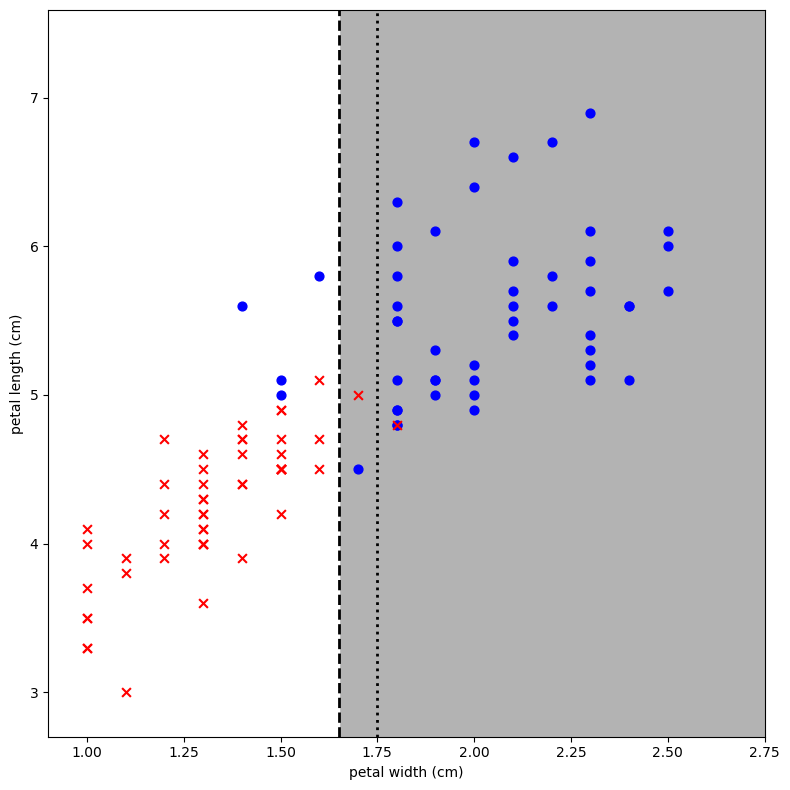

In [15]:
# Visualization of decision boundary for Iris Viginica and Versicolor
COLOUR_FIGURE = False

from matplotlib import pyplot as plt
from sklearn.datasets import load_iris

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['figure.dpi'] = 100

data = load_iris()
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

# We use NumPy fancy indexing to get an array of strings:
labels = target_names[target]

is_setosa = (labels == 'setosa')
features = features[~is_setosa]
labels = labels[~is_setosa]
is_virginica = (labels == 'virginica')

# Hand fixed thresholds:
t = 1.65
t2 = 1.75

# Features to use: 3 & 2
f0, f1 = 3, 2

if COLOUR_FIGURE:
    area1c = (1., .8, .8)
    area2c = (.8, .8, 1.)
else:
    area1c = (1., 1, 1)
    area2c = (.7, .7, .7)

# Plot from 90% of smallest value to 110% of largest value
# (all feature values are positive, otherwise this would not work very well)

x0 = features[:, f0].min() * .9
x1 = features[:, f0].max() * 1.1

y0 = features[:, f1].min() * .9
y1 = features[:, f1].max() * 1.1

fig,ax = plt.subplots()
ax.fill_between([t, x1], [y0, y0], [y1, y1], color=area2c)
ax.fill_between([x0, t], [y0, y0], [y1, y1], color=area1c)
ax.plot([t, t], [y0, y1], 'k--', lw=2)
ax.plot([t2, t2], [y0, y1], 'k:', lw=2)
ax.scatter(features[is_virginica, f0],
            features[is_virginica, f1], c='b', marker='o', s=40)
ax.scatter(features[~is_virginica, f0],
            features[~is_virginica, f1], c='r', marker='x', s=40)
ax.set_ylim(y0, y1)
ax.set_xlim(x0, x1)
ax.set_xlabel(feature_names[f0])
ax.set_ylabel(feature_names[f1])
fig.tight_layout()

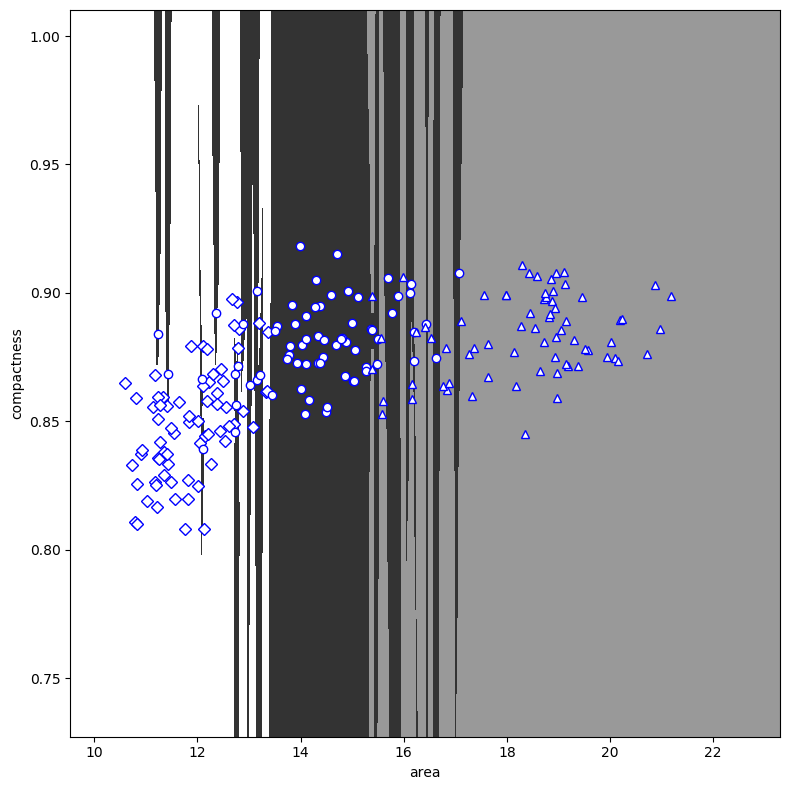

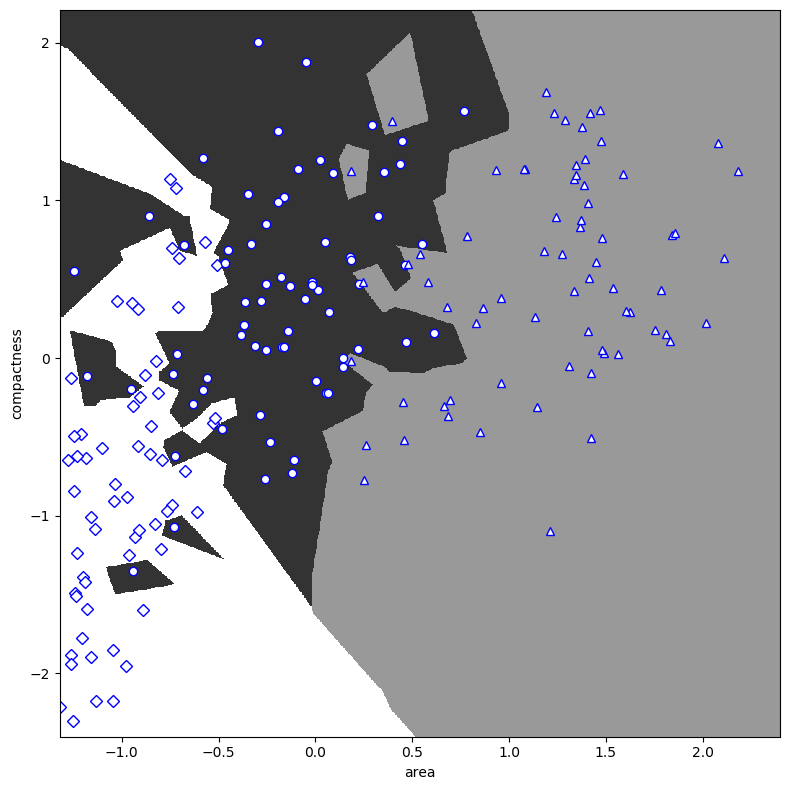

In [16]:
# Visualization of decision boundary for Seeds dataset

COLOUR_FIGURE = False

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def load_dataset(dataset_name):
    data = []
    labels = []
    with open('./{0}.tsv'.format(dataset_name)) as ifile:
        for line in ifile:
            tokens = line.strip().split('\t')
            data.append([float(tk) for tk in tokens[:-1]])
            labels.append(tokens[-1])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]


def plot_decision(features, labels, num_neighbors=1):
    '''Plots decision boundary for KNN
    Parameters
    ----------
    features : ndarray
    labels : sequence
    Returns
    -------
    fig : Matplotlib Figure
    ax  : Matplotlib Axes
    '''
    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)

    model = KNeighborsClassifier(num_neighbors)
    model.fit(features[:, (0,2)], labels)
    C = model.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    if COLOUR_FIGURE:
        cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])
    fig,ax = plt.subplots()
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    if COLOUR_FIGURE:
        cmap = ListedColormap([(1., .0, .0), (.1, .6, .1), (.0, .0, 1.)])
        ax.scatter(features[:, 0], features[:, 2], c=labels, cmap=cmap)
    else:
        for lab, ma in zip(range(3), "Do^"):
            ax.plot(features[labels == lab, 0], features[labels == lab, 2], ma, c=(1., 1., 1.), ms=6, mec='b')
    return fig,ax


features, labels = load_dataset('seeds')
names = sorted(set(labels))
labels = np.array([names.index(ell) for ell in labels])

fig,ax = plot_decision(features, labels)
fig.tight_layout()

features -= features.mean(0)
features /= features.std(0)
fig,ax = plot_decision(features, labels)
fig.tight_layout()